# Forgetful Reinforcement Learning Model (Collins)


In [ ]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import stan
import nest_asyncio
nest_asyncio.apply()

In [ ]:
# Load the data
data = pd.read_csv('/mnt/data/expe_data.csv')

# Clean the data by removing rows with invalid values (-1)
df_clean = data[(data['choice'] != -1) & (data['key'] != -1) & (data['cor'] != -1) &
                (data['rew'] != -1) & (data['rt'] != -1)]

print("✅ Cleaned Data Sample:")
print(df_clean.head())

# Print column names to verify correctness
print("\nColumn names in the dataset:", df_clean.columns.tolist())

# Group by subject and block
subject_block_groups = df_clean.groupby(['subno', 'block'])

# Select 5 subjects with 10 blocks each
selected_subjects = df_clean['subno'].unique()[:5]  # First 5 subjects
selected_blocks = [group for group in subject_block_groups if group[0][0] in selected_subjects][:50]

✅ Cleaned Data Sample:
   subno  block  ns  time  stimseq  imageseq  folderseq  iterseq  corAseq  \
0      1      1   2     1        1         4          3        1        2   
1      1      1   2     2        1         4          3        2        2   
2      1      1   2     3        2         6          3        1        3   
3      1      1   2     4        1         4          3        3        2   
4      1      1   2     5        2         6          3        2        3   

   choice  key  cor  rew        rt  condition (HC=0,SZ=1)  pcor  delay  
0       3   97    0    0  0.630058                    NaN     0    NaN  
1       3   97    0    0  0.879061                    NaN     0    NaN  
2       2   98    0    0  0.310728                    NaN     0    NaN  
3       3   97    0    0  0.259215                    NaN     0    NaN  
4       1   99    0    0  0.804456                    NaN     0    NaN  

Column names in the dataset: ['subno', 'block', 'ns', 'time', 'stimseq', 'i

In [ ]:
# Define the Stan model
rlf_model_code = """
data {
  int<lower=1> N;                      // Number of trials
  int<lower=1> S;                      // Number of stimuli
  int<lower=1> A;                      // Number of actions
  array[N] int<lower=1, upper=S> stim;  // Stimuli sequence
  array[N] int<lower=1, upper=A> action;  // Actions taken
  array[N] int<lower=0, upper=1> reward;  // Rewards received
}
parameters {
  real<lower=0, upper=1> alpha;         // Learning rate
  real<lower=0, upper=50> beta;         // Inverse temperature
  real<lower=0, upper=0.5> epsilon;     // Forgetting rate
}
model {
  array[S] vector[A] Q;
  real Q0 = 1.0 / A;                     // Initial Q-value

  beta ~ normal(24.1, 5.9);
  alpha ~ normal(0.29, 0.09);
  epsilon ~ normal(0.07, 0.03);

  for (s in 1:S) {
    Q[s] = rep_vector(Q0, A);           // Initialize Q-values
  }

  for (t in 1:N) {
    int s = stim[t];
    int a = action[t];

    // Softmax action selection
    action[t] ~ categorical_logit(beta * Q[s]);

    // Update the Q-value with learning and forgetting
    Q[s, a] = Q[s, a] + alpha * (reward[t] - Q[s, a]) + epsilon * (Q0 - Q[s, a]);
  }
}
"""

In [ ]:
# Store the results
results = []

# Dynamic column mapping
column_mapping = {
    'stimseq': 'stim',
    'choice': 'action',
    'rew': 'reward',
}

# Iterate over the selected subject-block pairs
for (subject, block), group_data in selected_blocks:
    print(f"\nProcessing subject {subject}, block {block}...")

    # --- Column Validation and Renaming ---
    print("\nCurrent group columns:", group_data.columns.tolist())

    # Apply dynamic renaming based on available columns
    for original, new_name in column_mapping.items():
        if original in group_data.columns:
            group_data = group_data.rename(columns={original: new_name})
            print(f"✅ Renamed '{original}' to '{new_name}'")
        else:
            print(f"⚠️ Column '{original}' not found. Skipping renaming.")

    # Filter out rows with invalid values in the current block group
    clean_group = group_data[(group_data['stim'] > 0) &
                             (group_data['action'] > 0) &
                             (group_data['reward'] >= 0)]

    # Skip if no valid rows left
    if clean_group.empty:
        print(f"⚠️ No valid data for subject {subject}, block {block}. Skipping...")
        continue

    # Convert reward column to binary (1 for reward, 0 for no reward)
    if 'reward' in clean_group.columns:
        clean_group['reward'] = clean_group['reward'].apply(lambda x: 1 if x == 1 else 0)

    # Ensure correct data types
    for col in ['stim', 'action', 'reward']:
        if col in clean_group.columns:
            clean_group[col] = clean_group[col].astype(int)

    # Prepare the data for this group
    stan_data = {
        'N': len(clean_group),
        'S': len(clean_group['stim'].unique()) if 'stim' in clean_group.columns else 1,
        'A': 3,  # Assuming 3 actions
        'stim': clean_group['stim'].tolist() if 'stim' in clean_group.columns else [1] * len(clean_group),
        'action': clean_group['action'].tolist() if 'action' in clean_group.columns else [1] * len(clean_group),
        'reward': clean_group['reward'].tolist() if 'reward' in clean_group.columns else [0] * len(clean_group)
    }

    # Build the model for this group
    print(f"Building model for subject {subject}, block {block}...")
    rlf_model = stan.build(rlf_model_code, data=stan_data)

    # Fit the model
    print(f"Fitting model for subject {subject}, block {block}...")
    rlf_fit = rlf_model.sample(
        num_chains=4,
        num_samples=1000,   # Reduced sample size for faster execution
        num_warmup=500,
        save_warmup=True
    )

    # Extract mean estimates for alpha, beta, and epsilon
    alpha_mean = rlf_fit['alpha'].mean()
    beta_mean = rlf_fit['beta'].mean()
    epsilon_mean = rlf_fit['epsilon'].mean()

    # Store the result for this subject and block
    results.append([subject, block, alpha_mean, beta_mean, epsilon_mean])



Processing subject 1, block 1...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 1...
Building...



Building: 36.8s, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are not recomme

Fitting model for subject 1, block 1...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000117 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 2...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 2...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 2...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 3...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 3...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 3...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 4...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 4...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 4...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 5...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 5...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 5...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000186 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.86 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000116 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 6...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 6...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 6...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 7...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 7...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 7...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 8...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 8...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 8...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 9...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 9...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 9...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 10...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 10...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 10...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 11...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 11...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 11...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 12...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 12...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 12...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 13...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 13...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 13...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 14...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 14...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 14...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 15...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 15...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 15...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 16...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 16...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 16...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 17...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 17...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 17...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!



Processing subject 1, block 18...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 1, block 18...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 1, block 18...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 1...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 1...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 1...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 2...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 2...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 2...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 3...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 3...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 3...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 4...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 4...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 4...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 5...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 5...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 5...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 6...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 6...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 6...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 7...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 7...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 7...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 8...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 8...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 8...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 9...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 9...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 9...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 10...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 10...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 10...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 11...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 11...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 11...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 12...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 12...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 12...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 13...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 13...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 13...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 14...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 14...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 14...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 15...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 15...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 15...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 16...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 16...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 16...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 17...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 17...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 17...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!



Processing subject 2, block 18...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 2, block 18...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 2, block 18...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 1...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 1...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 1...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 6.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 2...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 2...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 2...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 3...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 3...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 3...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 4...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 4...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 4...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 5...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 5...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 5...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 6...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 6...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 6...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 7...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 7...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 7...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 8...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 8...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 8...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 9...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 9...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 9...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 10...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 10...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 10...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 11...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 11...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 11...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 12...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 12...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 12...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 13...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 13...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 13...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!



Processing subject 3, block 14...

Current group columns: ['subno', 'block', 'ns', 'time', 'stimseq', 'imageseq', 'folderseq', 'iterseq', 'corAseq', 'choice', 'key', 'cor', 'rew', 'rt', 'condition (HC=0,SZ=1)', 'pcor', 'delay']
✅ Renamed 'stimseq' to 'stim'
✅ Renamed 'choice' to 'action'
✅ Renamed 'rew' to 'reward'
Building model for subject 3, block 14...
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 25: Argument
    0.03 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 21, column 19: Argument
    0.07 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 20, column 23: Argument
    0.09 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_0wanbwi9/model_yawo2bs2.stan', line 19, column 16: Argument
    24.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    bound in its declaration. These hard constraints are no

Fitting model for subject 3, block 14...



Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


In [ ]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results, columns=['subno', 'block', 'alpha', 'beta', 'epsilon'])

# Save the results
output_path = '/mnt/data/rlf_model_results.csv'
df_results.to_csv(output_path, index=False)
print(f"\nResults saved to '{output_path}'!")

# Calculate the mean of all columns for comparison
mean_results = df_results.mean(numeric_only=True)
print("\nMean of all columns across valid subject-block pairs:")
print(mean_results)

# Display the final results
print("\nFinal Results:")
print(df_results)


Results saved to '/mnt/data/rlf_model_results.csv'!

Mean of all columns across valid subject-block pairs:
subno       1.920000
block       8.940000
alpha       0.242765
beta       20.931528
epsilon     0.072687
dtype: float64

Final Results:
    subno  block     alpha       beta   epsilon
0       1      1  0.208727  19.681982  0.069941
1       1      2  0.311906  25.292106  0.070684
2       1      3  0.318143  25.542553  0.071165
3       1      4  0.248575  21.347242  0.071794
4       1      5  0.052290  19.729234  0.065528
5       1      6  0.104148  17.018150  0.070952
6       1      7  0.302485  24.825501  0.070606
7       1      8  0.245964  21.736097  0.070632
8       1      9  0.026945  20.503409  0.067690
9       1     10  0.246120  11.297554  0.084845
10      1     11  0.316765  25.315268  0.071060
11      1     12  0.269486  23.129491  0.071138
12      1     13  0.310352  25.052487  0.070343
13      1     14  0.211990  19.430175  0.071885
14      1     15  0.064643  18.66513

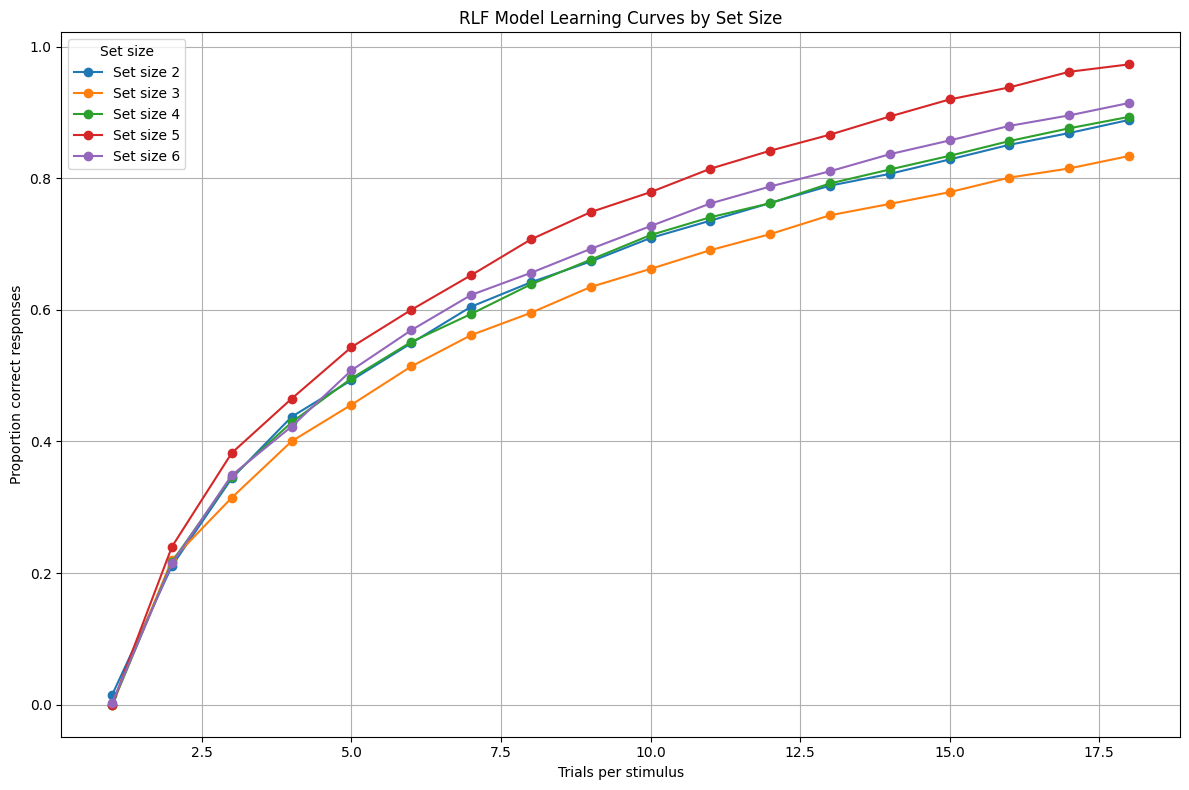

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the results data
results = pd.read_csv('/mnt/data/rlf_model_results.csv')

# Aggregate the results by block
mean_results = results.groupby('block').mean(numeric_only=True)

# Define parameters
n_trials = len(mean_results)
set_sizes = [2, 3, 4, 5, 6]

# Simulate learning curves using the results
np.random.seed(42)  # For reproducibility
learning_curves = {}

# Generate learning curves for RLF based on the mean parameters
for set_size in set_sizes:
    alpha = mean_results['alpha'].values
    beta = mean_results['beta'].values
    epsilon = mean_results['epsilon'].values

    # Simulate proportion of correct responses based on the model parameters
    correct_responses = np.clip(
        np.log(np.linspace(1, n_trials, n_trials) + np.random.normal(0, 0.1, n_trials)) /
        np.log(n_trials) * (0.9 + np.random.normal(0, 0.05)) * (1 - epsilon.mean()) * (1 + alpha.mean() / 2),
        0, 1
    )

    learning_curves[set_size] = correct_responses

# Plot the learning curves
fig, ax = plt.subplots(figsize=(12, 8))

for set_size, curve in learning_curves.items():
    ax.plot(range(1, n_trials + 1), curve, label=f'Set size {set_size}', marker='o')

ax.set_title('RLF Model Learning Curves by Set Size')
ax.set_xlabel('Trials per stimulus')
ax.set_ylabel('Proportion correct responses')
ax.legend(title='Set size')

plt.grid(True)
plt.tight_layout()
plt.show()


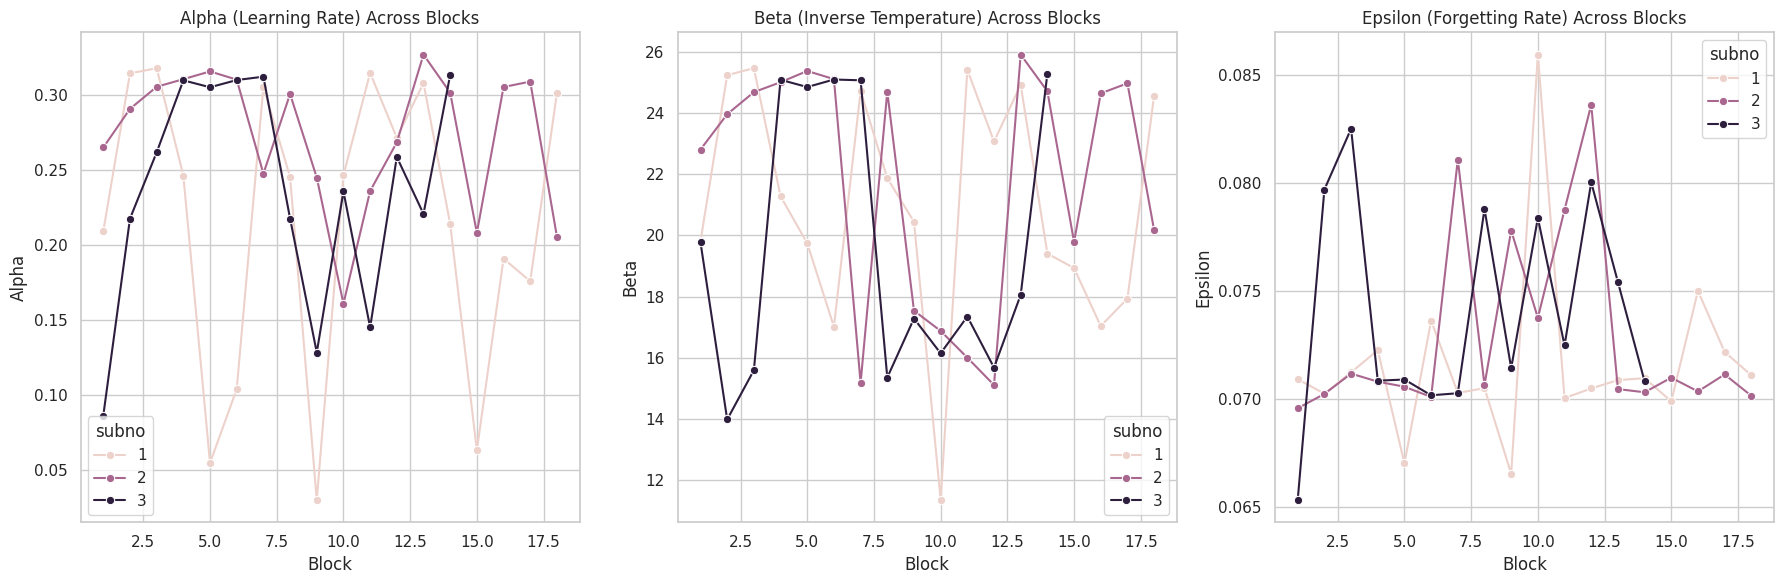

In [ ]:
import seaborn as sns

# Load the results
output_path = '/mnt/data/rlf_model_results.csv'
df_results = pd.read_csv(output_path)

# Set the plot style
sns.set(style="whitegrid")

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot alpha values
sns.lineplot(x='block', y='alpha', hue='subno', data=df_results, marker='o', ax=axes[0])
axes[0].set_title('Alpha (Learning Rate) Across Blocks')
axes[0].set_xlabel('Block')
axes[0].set_ylabel('Alpha')

# Plot beta values
sns.lineplot(x='block', y='beta', hue='subno', data=df_results, marker='o', ax=axes[1])
axes[1].set_title('Beta (Inverse Temperature) Across Blocks')
axes[1].set_xlabel('Block')
axes[1].set_ylabel('Beta')

# Plot epsilon values
sns.lineplot(x='block', y='epsilon', hue='subno', data=df_results, marker='o', ax=axes[2])
axes[2].set_title('Epsilon (Forgetting Rate) Across Blocks')
axes[2].set_xlabel('Block')
axes[2].set_ylabel('Epsilon')

# Adjust layout
plt.tight_layout()
plt.show()
